# How much does functional dependents contribute to the overall LAS?

We are interested in looking at the contribution of functional dependents to the overall LAS score. To do this, we look at the correlation between the LAS score of functional dependency classes, plotted against the frequency ratio of the dependency class. If there is a correlation between how common the dependency class is in the language and how common the class is, we can draw the conclusion that the more common functional dependencies are in a language, the easier it is to parse.

We also expect that such a correlation cannot be found in content classes.

## Summary

There is such a correlation for the functional dependency class, and we lack the same correlation for content classes.

In [1]:
# Matplotlib
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
mpl.style.use('ggplot')
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
#import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, udtree, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = False
file_format = "conllx"
test_type = "test"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltdefault_coarse_output_test_1-2/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "maltdefault"

system_files = lang_utils.get_system_output_paths(system_output_base, type_=test_type, format_=file_format)
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format, coarse=True)

In [2]:
las_scores = pd.Series.from_csv('../data/' + file_prefix + '.las.csv')
content_function_las = pd.DataFrame.from_csv('../data/' + file_prefix + '.content_function_deprels.las.csv', header=[0,1])
content_function_las

Function           Nonsemantic             Content  \
                    precision    recall   precision    recall precision   
Arabic               0.825058  0.810317    0.779388  0.749226  0.716505   
Basque               0.857873  0.823987    0.684042  0.593332  0.574014   
Bulgarian            0.921854  0.916795    0.818064  0.812098  0.772891   
Croatian             0.820272  0.814315    0.637931  0.594855  0.674652   
Czech                0.890820  0.875164    0.746595  0.695466  0.778110   
Danish               0.898154  0.879813    0.728411  0.662116  0.690546   
Dutch                0.844731  0.791076    0.648472  0.453435  0.571343   
English              0.921443  0.919656    0.775000  0.751632  0.784849   
Finnish              0.761481  0.762046    0.711940  0.692308  0.631938   
Gothic               0.804772  0.812409    0.732759  0.745614  0.616835   
Greek                0.894201  0.867292    0.619962  0.544688  0.651053   
Hebrew               0.922227  0.923529    0.690780  0.612194  0.697012   
Hindi                0.963245  0.962782    0.956348  0.895436  0.807023   
Italian              0.954366  0.954995    0.741564  0.728964  0.771964   
Norwegian            0.916245  0.931639    0.843332  0.807954  0.803790   
Old_Church_Slavonic  0.852444  0.836824    0.834254  0.743842  0.658627   
Persian              0.900920  0.880674    0.756857  0.728245  0.758404   
Polish               0.907010  0.903134    0.861301  0.859829  0.803204   
Portuguese           0.948301  0.941988    0.665428  0.621528  0.712555   
Slovenian            0.906062  0.899080    0.789474  0.748011  0.768859   
Spanish              0.918885  0.915484    0.649880  0.634660  0.692980   
Swedish              0.886657  0.874674    0.715663  0.706134  0.756714   

                               
                       recall  
Arabic               0.725658  
Basque               0.600554  
Bulgarian            0.776560  
Croatian             0.687672  
Czech                0.796339  
Danish               0.714676  
Dutch                0.631405  
English              0.790791  
Finnish              0.635584  
Gothic               0.614317  
Greek                0.679462  
Hebrew               0.716423  
Hindi                0.814800  
Italian              0.774656  
Norwegian            0.803504  
Old_Church_Slavonic  0.666220  
Persian              0.769813  
Polish               0.804598  
Portuguese           0.730000  
Slovenian            0.781116  
Spanish              0.698730  
Swedish              0.764176

In [3]:
from collections import defaultdict

def label_ratio(trees, label_class):
    deprel_freqs = 0
    total_deprels = 0
    for tree in trees:
        for deprel in tree.deprels:
            label = deprel.split(":")[0]
            total_deprels += 1
            if label in label_class:
                deprel_freqs += 1
    deprel_dist = deprel_freqs / total_deprels
    return deprel_dist

def language_deprel_ratio(treebank_paths, label_class):
    lang_deprels = {}
    for lang, path in treebank_paths.items():
        lang_deprels[lang] = label_ratio(udtree.from_files(path), label_class)
    return lang_deprels

lang_function_rels = pd.Series(language_deprel_ratio(gold_files, dependency_classes.function_dependents)).fillna(0)
lang_function_rels.to_csv('../data/' + file_prefix + '.function_dist.csv')
lang_function_rels

Arabic                 0.263337
Basque                 0.200460
Bulgarian              0.289500
Croatian               0.233697
Czech                  0.218871
Danish                 0.291298
Dutch                  0.341092
English                0.287655
Finnish                0.147593
Gothic                 0.265607
Greek                  0.357622
Hebrew                 0.350515
Hindi                  0.351877
Italian                0.415906
Norwegian              0.317074
Old_Church_Slavonic    0.225635
Persian                0.277743
Polish                 0.195407
Portuguese             0.358446
Slovenian              0.286070
Spanish                0.407645
Swedish                0.319527
dtype: float64

0.666145320824


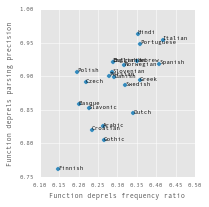

In [38]:
function_precision = pd.concat([lang_function_rels, content_function_las['Function']['precision']], axis=1)
function_precision.columns = ['Function deprels frequency ratio', 'Function deprels recall']

#from  scipy.stats import linregress
#linr = linregress(function_precision['Function deprels frequency ratio'], function_precision['Function deprels LAS'])

ax = function_precision.plot(kind='scatter', x='Function deprels frequency ratio', y='Function deprels recall', figsize=(3,3), fontsize=6)
#plt.plot(np.arange(0,0.6,0.1), (linr.slope*np.arange(0,0.6,0.1) + linr.intercept), '-')
plt.xlabel("Function deprels frequency ratio", fontsize=7)
plt.ylabel("Function deprels parsing precision", fontsize=7)
for lang, x, y in function_precision.itertuples():
    if lang == "Old_Church_Slavonic":
        lang = "Slavonic"
    ax.annotate(lang, (x, y), fontsize=6)

corr = function_precision.corr().ix[0,1]
print(corr)
plt.xlim(0.1, 0.5)
plt.ylim(0.75, 1.0)
#ax.annotate("R = {0:.2f}".format(corr), (0.12, 0.98))
plt.tight_layout()
plt.savefig("../paper/figures/function_deprel_las_ratio_corr.pgf")

LinregressResult(slope=0.50404182766712213, intercept=0.73047756884939408, rvalue=0.62311816267133169, pvalue=0.0019490439306524953, stderr=0.14146820482676106)

In [5]:
core_las = pd.DataFrame.from_csv('../data/maltdefault.ud_classes.las.csv', header=[0,1])['core']['precision']
core_ratio = pd.Series(language_deprel_ratio(gold_files, dependency_classes.core_dependents))
core_las_ratio = pd.concat([core_las, core_ratio], axis=1)
core_las_ratio.columns = ['Core deprels frequency ratio', 'Core deprels LAS']

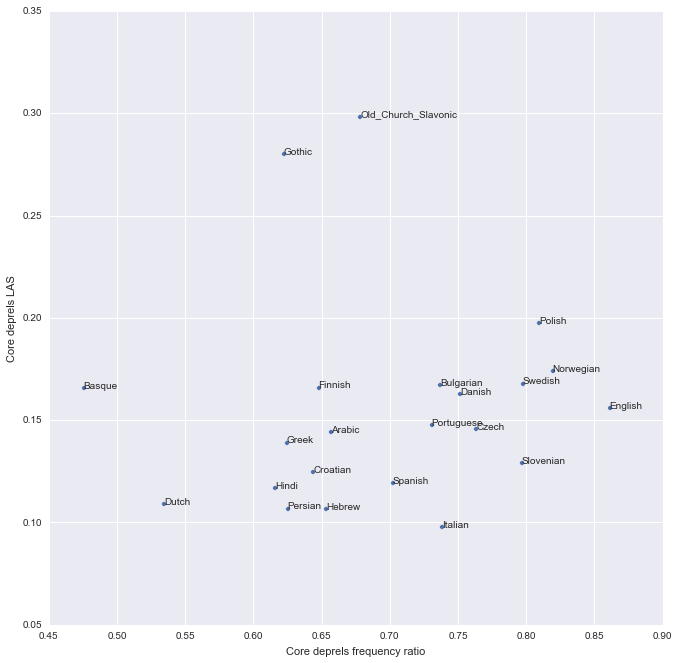

In [6]:
ax = core_las_ratio.plot(kind='scatter', x='Core deprels frequency ratio', y='Core deprels LAS', figsize=(11,11))
for lang, x, y in core_las_ratio.itertuples():
    ax.annotate(lang, (x, y))

-0.331596899515


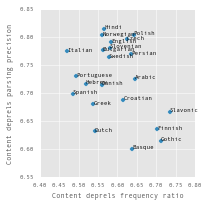

In [36]:
lang_content_rels = pd.Series(language_deprel_ratio(gold_files, dependency_classes.content_dependents)).fillna(0)
lang_content_rels.to_csv('../data/' + file_prefix + '.content_dist.csv')
content_precision = pd.concat([lang_content_rels, content_function_las['Content']['recall']], axis=1)
content_precision.columns = ['Content deprels frequency ratio', 'Content deprels LAS']
ax = content_precision.plot(kind='scatter', x='Content deprels frequency ratio', y='Content deprels LAS', figsize=(3,3), fontsize=6)
plt.xlabel("Content deprels frequency ratio", fontsize=7)
plt.ylabel("Content deprels parsing precision", fontsize=7)
for lang, x, y in content_precision.itertuples():
    if lang == "Old_Church_Slavonic":
        lang = "Slavonic"
    ax.annotate(lang, (x, y), fontsize=6)
    
corr = content_precision.corr().ix[0,1]
print(corr)
#ax.annotate("$\\rho = {0:.2f}$".format(corr), (0.46, 0.84), size="x-large")
plt.tight_layout()
plt.savefig("../paper/figures/content_deprel_las_ratio_corr.pgf")